# 0th Order Quality Control of DAS Data - Data Coverage

This notebook is for 1st order quality control of data recorded with the Sintela Onyx interrogator. It looks through all files within a given directory and searches for data gaps in the data. The output is a time series plot showing the data coverage with data gaps.\
\
This script will run approximately 10ms per file (for data with not too many data gaps [~1000])

In [1]:
# load modules
import glob
import numpy as np
import matplotlib.pyplot as plt
import h5py
import datetime
import os
import DASfuncs

In [41]:
# get all file names
files = glob.glob('/Users/graeffd/tmp/Samsung_2TB/ManualRecorders/data_2kiloHz/*h5') # replace with your data directory
# files = glob.glob('../../../data/lab/SaltwaterTankTest/DAS_data/*')
files.sort()
print('{} files in directory'.format(len(files)))

1045 files in directory


In [40]:
# little helper functions
def get_fname_time(filename):
    '''returns datetime.datetime of filename'''
    date = os.path.basename(filename).split('_')[-3]
    time = os.path.basename(filename).split('_')[-2]
    time = datetime.datetime.strptime('{}T{}'.format(date, time), '%Y-%m-%dT%H.%M.%S')
    return time

In [61]:
# get data gaps from files and write into lists
gap_info = {}
t_filenames = []
t_span_files = []
t_gaps = []
t_file_gaps = []

for file_idx in range(len(files)):
    print(r"Processing file {} of {}.".format(file_idx+1, len(files)), end="\r")
    try:
        f = h5py.File(files[file_idx],'r')
        attrs = dict(f['Acquisition'].attrs)
        times = np.array(f['Acquisition/Raw[0]/RawDataTime'])
        f.close()

        # times in filenames
        filename = os.path.basename(files[file_idx])
        fname_time = get_fname_time(filename)
        t_filenames.append(fname_time)

        # first and last sample
        t_span_files.append((DASfuncs.sintela_to_datetime(times[0]),
                             DASfuncs.sintela_to_datetime(times[-1])))

        # data gaps within file
        dt_nom = 1/attrs['PulseRate']
        gap_idx = np.where(np.diff(times)/1e6 > dt_nom)[0]
        if len(gap_idx)>0:
            t_gaps.extend(list(zip(DASfuncs.sintela_to_datetime(times[gap_idx]), 
                            DASfuncs.sintela_to_datetime(times[gap_idx+1]))))
            length_all = np.sum([(t2-t1).total_seconds() for t1,t2 in list(zip(DASfuncs.sintela_to_datetime(times[gap_idx]), 
                                 DASfuncs.sintela_to_datetime(times[gap_idx+1])))])
            gap_info[filename] = {'num_gaps':len(gap_idx), 
                                      'total_length':length_all}
            
        # data gaps between files (last sample of file to future file first sample)
        if file_idx<len(files)-1:
            eps = dt_nom/10. # tolerance
            f_next = h5py.File(files[file_idx+1],'r')
            next_time = np.array(f_next['Acquisition/Raw[0]/RawDataTime'])[0]
            f_next.close()
            if (next_time-times[-1])/1e6 > dt_nom+eps:
                t_file_gaps.append((DASfuncs.sintela_to_datetime(times[-1]),
                                    DASfuncs.sintela_to_datetime(next_time)))
    except:
        pass
        
# calculate total data gap share
t_gaps_total = 0.
for t_start, t_end in t_gaps:
    t_gaps_total += (t_end-t_start).total_seconds()
for t_start, t_end in t_file_gaps:
    t_gaps_total += (t_end-t_start).total_seconds()
gaps_share = t_gaps_total/(t_span_files[-1][1]-t_span_files[0][0]).total_seconds()
print('')
print('{} data gap(s) found'.format(len(t_gaps)+len(t_file_gaps)))

Processing file 1045 of 1045.
176 data gap(s) found


Text(0, 0.5, 'Counts')

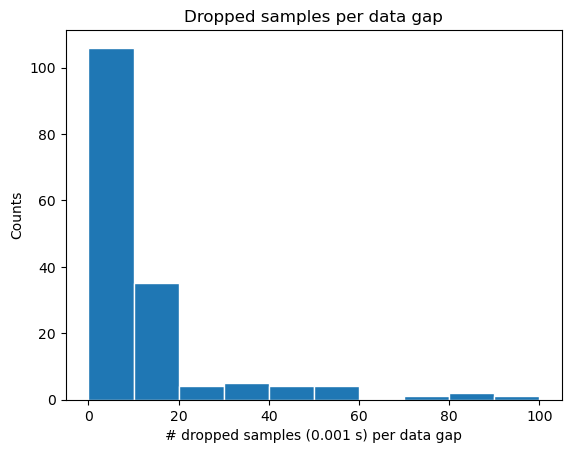

In [93]:
# plot histogram of data gap lengths
gap_lengths1 = [(t1-t0).total_seconds() for t0,t1 in t_gaps]
gap_lengths2 = [(t1-t0).total_seconds() for t0,t1 in t_file_gaps]
gap_lengths = gap_lengths1 + gap_lengths2
gap_samples = (gap_lengths-2*1/attrs['PulseRate'])/(1/attrs['PulseRate'])
_ = plt.hist(gap_samples, 
             bins=range(int(0),int(np.percentile(gap_samples,99)),int(10)),
             edgecolor='white')
plt.title('Dropped samples per data gap')
plt.xlabel('# dropped samples ({:.3f} s) per data gap'.format(1/attrs['PulseRate']))
plt.ylabel('Counts')
# plt.yscale('log')

In [94]:
# to vizualize really short data gaps (only a few samples), set to 'True'
show_short = True #False/True

Text(0.5, 1.0, 'Data Coverage:  2023-07-06 23:24:49 - 2023-07-07 16:48:12  UTC')

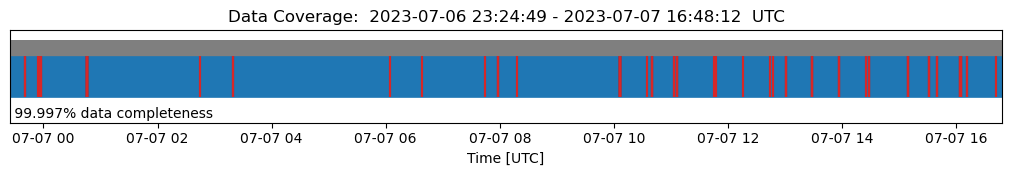

In [109]:
# plot data coverage and gaps
fig, ax = plt.subplots(figsize=(6.4*2,4.8/4.))

# file start
plt.vlines(t_filenames, -0.0, 0.04, color='C7', zorder=0)
# time sample spaning for each file
plt.hlines(np.full(len(t_span_files),0), 
           [t[0] for t in t_span_files], 
           [t[1] for t in t_span_files], linewidth=30, color='C0')
# data gaps within the each file
plt.hlines(np.full(len(t_gaps),0), 
           [t[0] for t in t_gaps], 
           [t[1] for t in t_gaps], linewidth=30, color='C3')
# data gaps between two files
plt.hlines(np.full(len(t_file_gaps),0), 
           [t[0] for t in t_file_gaps], 
           [t[1] for t in t_file_gaps], linewidth=30, color='C3')

if show_short: #show really short data gaps
    plt.vlines([t[0] for t in t_gaps], -0.022, 0.022, 
               color='C3') 
    plt.vlines([t[0] for t in t_file_gaps], -0.022, 0.022, 
               color='C3')

ax.set_yticks([])
ax.set_xlim(t_span_files[0][0],t_span_files[-1][1])
ax.set_ylim(-0.05,0.05)
ax.set_xlabel('Time [UTC]')
plt.text(t_span_files[0][0],-0.045,' {:.3f}% data completeness'.format(100*(1-gaps_share)))
plt.title('Data Coverage:  {} - {}  UTC'.format(t_span_files[0][0].strftime('%Y-%m-%d %H:%M:%S'), 
                                            t_span_files[-1][1].strftime('%Y-%m-%d %H:%M:%S')))

**Legend:** *blue:* data;  *red:* no data;  *grey:* start of file

In [83]:
# print the files that include data gaps
for key in gap_info.keys():
    print(key)
    print(gap_info[key])

decimator_2023-07-06_23.40.53_UTC.h5
{'num_gaps': 4, 'total_length': 0.029501}
decimator_2023-07-06_23.53.53_UTC.h5
{'num_gaps': 2, 'total_length': 0.022501}
decimator_2023-07-06_23.56.53_UTC.h5
{'num_gaps': 3, 'total_length': 0.013498}
decimator_2023-07-06_23.57.53_UTC.h5
{'num_gaps': 5, 'total_length': 0.06449400000000001}
decimator_2023-07-07_00.45.53_UTC.h5
{'num_gaps': 21, 'total_length': 0.080015}
decimator_2023-07-07_02.44.53_UTC.h5
{'num_gaps': 2, 'total_length': 0.021998}
decimator_2023-07-07_03.18.53_UTC.h5
{'num_gaps': 4, 'total_length': 0.033001}
decimator_2023-07-07_06.04.53_UTC.h5
{'num_gaps': 2, 'total_length': 0.014001}
decimator_2023-07-07_06.37.53_UTC.h5
{'num_gaps': 2, 'total_length': 0.057996}
decimator_2023-07-07_07.44.53_UTC.h5
{'num_gaps': 2, 'total_length': 0.013991}
decimator_2023-07-07_07.57.53_UTC.h5
{'num_gaps': 6, 'total_length': 0.024512}
decimator_2023-07-07_08.17.53_UTC.h5
{'num_gaps': 2, 'total_length': 0.026001}
decimator_2023-07-07_10.06.53_UTC.h5
{'n

Text(0, 0.5, 'Counts')

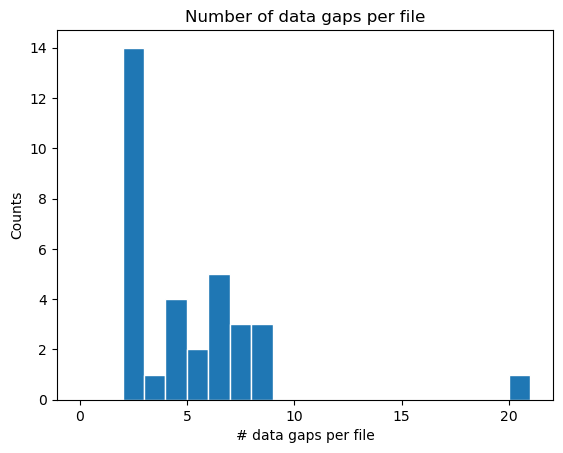

In [91]:
# plot histogram showing number of data gaps per file
gaps_per_file = []
for key, value in gap_info.items():
    gaps_per_file.append(value['num_gaps'])
_ = plt.hist(gaps_per_file, 
             bins=range(int(0),int(np.max(gaps_per_file)),int(1)),
             edgecolor='white')
plt.title('Number of data gaps per file')
plt.xlabel('# data gaps per file')
plt.ylabel('Counts')
# plt.yscale('log')